In [104]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
from numba import jit, njit, prange
from sympy import isprime, primerange
from sympy.utilities.iterables import multiset_permutations
from tqdm import tqdm_notebook as tqdm
np.random.seed(seed=42)
df = pd.read_csv('submission_close.csv')
cities = pd.read_csv('input/cities.csv')

In [105]:
primes = np.array(list(primerange(0, len(cities))))
complexes = (cities.X + 1j * cities.Y).values
path = df.Path.values
[primes.shape, complexes.shape, path.shape]

[(17802,), (197769,), (197770,)]

In [130]:
#@jit
def dist2(a, b):
    #return np.abs(complexes[a] - complexes[b])
    d = ((cities.X.values[a] - cities.X.values[b])**2 + (cities.Y.values[a] - cities.Y.values[b])**2)**0.5
    return d

In [107]:
def dist(a, b):
    return np.abs(complexes[a] - complexes[b])

In [108]:
#@jit('i4(i4[:], i4)')
def closest(path, base_index):
    min_dist = np.inf
    closest_index = -1
    for i in path:
        d = dist(base_index, i)
        if d < min_dist and i != base_index:
            min_dist = d
            closest_index = i
    return closest_index

In [124]:
#@jit('i4(i4)')
def closest_prime(base_index):
    min_dist = np.inf
    closest_index = -1
    for i in primes:
        d = dist(base_index, i)
        if d < min_dist and i != base_index:
            min_dist = d
            closest_index = i
    return closest_index

In [110]:
def score_between2(path, a, b):
    #c = np.array([complexes[path[i]] for i in range(a, b+1)])
    c = complexes[path[a: b+1]]
    sc = np.sum(np.abs(np.diff(c)))
    pn = np.sum(np.array([np.abs(complexes[path[i-1]] - complexes[path[i]])*0.1 for i in range(a, b+1) if i > 0 and a != i and i % 10 == 0 and isprime(path[i-1]) == False]))
    return sc + pn

In [118]:
@jit('f4(i4[:], i4, i4)', parallel=True)
def score_between3(path, a, b):
    d = 0
    pn = 0
    for i in range(a+1, b+1):
        d += dist(path[i-1], path[i])
        if i % 10 == 0 and isprime(path[i-1]) == False:
            pn += dist(path[i-1], path[i])*0.1
    return d + pn

score_between(path, 10, 11)     

6.815530169782283

In [129]:
#@jit('f4(i4[:], i4, i4)', parallel=True)
def score_between(path, a, b):
    c = complexes[path[a: b+1]]
    sc = np.sum(np.abs(np.diff(c)))
    pn = 0
    for i in range(a+1, b+1):
        if i % 10 == 0:
            if isprime(path[i-1]) == False:
                pn += np.abs(complexes[path[i-1]] - complexes[path[i]]) * 0.1

    return sc + pn

In [120]:
score_between(path, 0, len(path)-1)
# 1503341.190867061
#1516697.3833748524
# (1503430.5071311188, 13264.683401763945)

1516242.6576196954

In [133]:
@jit(parallel=True)
def opt_prime(path):
    sum1 = 0
    sum2 = 0
    for i in tqdm(prange(0, len(path), 10)):
        if i > 0:
            p = isprime(path[i-1])
            if p == False:
                closest_prime_index = closest_prime(path[i-2])
                closest_prime_path_index = np.where(path==closest_prime_index)[0][0]
                if closest_prime_path_index < i-1:
                    s1 = score_between(path, closest_prime_path_index-1, i)
                    path_copy = np.insert(path, i, closest_prime_index)
                    path_copy = np.delete(path_copy, closest_prime_path_index)
                    s2 = score_between(path_copy, closest_prime_path_index-1, i)
                    if s1 > s2:
                        sum1 += 1
                        path = path_copy
                        print('sum1:', sum1, i, score_between(path, 0, len(path)-1))
                elif closest_prime_path_index > i-1:
                    s1 = score_between(path, i-2, closest_prime_path_index+1)
                    path_copy = np.insert(path, i-1, closest_prime_index)
                    path_copy = np.delete(path_copy, closest_prime_path_index+1)
                    s2 = score_between(path_copy, i-2, closest_prime_path_index+1)
                    if s1 > s2:
                        sum2 += 1
                        path = path_copy
                        print('sum2:', sum2, i, score_between(path, 0, len(path)-1))
    return path

In [ ]:
path = opt_prime(path)
score_between(path, 0, len(path)-1)

# 1516845.1618924788 --> 1516774.6045630828 (-70.55732939601876) --> 1516761.7762980566
# 1517948.690835177  11m 52s

In [83]:
#pd.DataFrame({'Path': path}).to_csv('submission.csv', index=False)

In [9]:
score_between(path, 0, len(path)-1)
# 1516763.9051902506
# 1516761.7762980566
# 1516748.2666537983
# 1516737.7108732369

1516706.0565010002

In [228]:
def opt2(path):
    cnt = 0
    for i in tqdm(range(1, len(path)-2)):
        copy = path.copy()
        sc1 = score_between(path, i-1, i+2)
        copy[i], copy[i+1] = copy[i+1], copy[i]
        sc2 = score_between(copy, i-1, i+2)
        if sc1 > sc2:
            path = copy.copy()
            cnt += 1
            print(cnt, i)
    return path
    

In [265]:
path = opt2(path)
score_between(path, 0, len(path)-1)
# 1516748.2666537983
# 1516747.6841528402
# 1516747.4665066132
# 1516745.9212705924
# 1516742.2739110142

1516737.4080211273

In [16]:
def opt3(path):
    cnt = 0
    for i in tqdm(range(2, len(path)-3)):
        copy = path.copy()
        sc1 = score_between(path, i-2, i+2)
        #copy[i-1], copy[i+1] = copy[i+1], copy[i-1]
        #copy[i-1], copy[i], copy[i+1] = copy[i], copy[i+1], copy[i-1]
        copy[i-1], copy[i], copy[i+1] = copy[i], copy[i-1], copy[i+1]
        sc2 = score_between(copy, i-2, i+2)
        if sc1 > sc2:
            path = copy.copy()
            cnt += 1
            print(cnt, i)
            
    return path

In [17]:
path = opt3(path)
score_between(path, 0, len(path)-1)

1516713.7760386425

In [143]:
def opt_n(path, n):
    cnt = 0
    for i in tqdm(range(1, len(path)-n-1)):
        perm = [path[i+n] for n in range(n)]
        combs = list(multiset_permutations(perm))
        new_combs = [p for p in combs if p[0] != perm[0] and p[-1] != perm[-1]]
        sc1 = score_between(path, i-1, i+n+1)
        for c in new_combs:
            copy = np.concatenate([path[:i], c, path[i+n:]])
            sc2 = score_between(copy, i-1, i+n+1)
            if sc1 > sc2:
                path = copy.copy()
                cnt += 1
                print(cnt, i, score_between(path, 0, len(path)-1))

    return path

In [146]:
path = opt_n(path, 4) # 3:1m48s, 4:6m, 5:29m5s, 6:3h, 7:21h
score_between(path, 0, len(path)-1)
# 1516742.2739110142

# 1503349.0689084984
# 1503344.3466409347

1516242.6576196954

In [159]:
@jit('i4[:](i4[:], i4)', parallel=True)
def opt_n_flip(path, n):
    cnt = 0
    for n1 in tqdm(prange(1, len(path)-n-1)):
        n2 = n1 + n
        sc1 = score_between(path, n1-1, n2+1)
        rev = path[n1: n2+1][::-1]
        #copy = np.concatenate([path[:n1], rev, path[n2+1:]])
        copy = path.copy()
        copy[n1: n2+1] = rev
        sc2 = score_between(copy, n1-1, n2+1)
        if sc1 > sc2:
            path = copy.copy()
            cnt += 1
            print(cnt, score_between(path, 0, len(path)-1))
    return path

In [160]:
n = 1000
for i in tqdm(range(n, n+100)): 
    path = opt_n_flip(path, i) # i=1: 25s, 10:250s, 100:2500s=42m, 1000:25000s=7h
score_between(path, 0, len(path)-1)

1516242.6576196954

In [ ]:
def closest_n(path, num, index):
    copy = path.copy().tolist()
    copy.remove(copy[index])
    copy.remove(copy[-1])
     
    d = np.array([dist(copy[index], i) for i in copy])
    arg = np.argsort(d)
    sorted_index = [copy[i] for i in arg][:num]
    return sorted_index

copy = path.copy()
perm = [closest_n(copy, 5, i) for i in tqdm(range(len(path)))]

In [389]:

def opt_closest(path, num, index):
    perm = closest_n(path, num, index)
    perm_index = [path.tolist().index(i) for i in perm]
    combs = list(multiset_permutations(perm))
    sc1 = score_between(path, 0, len(path)-1)
    for c in combs:
        if c != perm:
            copy = path.copy()
            for i in range(len(c)):
                copy[perm_index[i]] = c[i]
            sc2 = score_between(copy, 0, len(copy)-1)
            if sc1 > sc2:
                path = copy.copy()
                print(sc2)
                pd.DataFrame({'Path': path}).to_csv('ex_submission.csv', index=False)

                
score_between(path, 0, len(path)-1)

1516695.8182407494

In [ ]:
for i in tqdm(range(0, len(path)-1)):
    opt_closest(path, 3, i)
score_between(path, 0, len(path)-1)

In [131]:
@jit('i8[:](i8[:], i4)')
def opt_rand_flip(path, iteration=1000):
    cnt = 0
    for i in tqdm(range(iteration)):
        n1 = np.random.randint(1, len(path)-3)
        n2 = np.random.randint(n1+1, len(path)-2)
        sc1 = score_between(path, n1-1, n2+1)
        rev = path[n1: n2+1][::-1]
        copy = np.concatenate([path[:n1], rev, path[n2+1:]])
        sc2 = score_between(copy, n1-1, n2+1)
        if sc1 > sc2:
            path = copy.copy()
            cnt += 1
            print(cnt, score_between(path, 0, len(path)-1))
    return path


In [268]:
path = opt_rand_flip(path, 10000) # 10000:10m
score_between(path, 0, len(path)-1)

1516737.4080211273

In [24]:
@jit('i8[:](i8[:], i4)')
def opt_rand(path, iteration=1000):
    cnt = 0    
    for i in tqdm(range(iteration)):
        n1 = np.random.randint(1, len(path)-4)
        n2 = np.random.randint(n1+1, len(path)-3)
        copy = path.copy()
        sc1 = score_between(path, n1-1, n2+1)
        copy[n1], copy[n2] = copy[n2], copy[n1]
        sc2 = score_between(copy, n1-1, n2+1)
        if sc1 > sc2:
            path[n1], path[n2] = path[n2], path[n1]
            cnt += 1
            print(cnt, i)         
    return path

In [26]:
path = opt_rand(path, 1000)
score_between(path, 0, len(path)-1)
# 100000: 1h 58m 4s

1794317.8320420806

In [469]:
pd.DataFrame({'Path': path}).to_csv('submission.csv', index=False)

In [14]:
# flip it: https://www.kaggle.com/matthewa313/flip-it

tour = pd.read_csv('submission.csv')['Path'].tolist()
cities = pd.read_csv('input/cities.csv')

# Define a function for length of a path:
import numpy as np
from sympy import primerange
primes = list(primerange(0, len(cities)))
def score_tour(tour):
    # length of any given tour with primes calculation
    df = cities.reindex(tour + [0]).reset_index()
    df['prime'] = df.CityId.isin(primes).astype(int)
    df['dist'] = np.hypot(df.X - df.X.shift(-1), df.Y - df.Y.shift(-1))
    df['penalty'] = df['dist'][9::10] * (1 - df['prime'][9::10]) * 0.1
    return df.dist.sum() + df.penalty.sum()

# Let's take a look at our tour
print("Tour path (0-5):",tour[0:5])
# And the flipped tour looks like:
tourflip = tour[::-1]
print("Flipped tour path (0-5):", tourflip[0:5])
# The scores of our tours are:
print("Score of original tour:", score_tour(tour))
print("Score of flipped tour:", score_tour(tourflip))

# If the flipped tour is quicker, change our tour:
if score_tour(tourflip) < score_tour(tour):
    print("The total improvement was:", abs(score_tour(tourflip) - score_tour(tour)))
    tour = tourflip 
    print("The better of the original/flipped tour is:", tour[0:5])

#pd.DataFrame({'Path': list(tour)}).to_csv('submission.csv', index=False)

Tour path (0-5): [0, 78934, 111804, 52086, 89712]
Flipped tour path (0-5): [0, 48816, 40230, 75405, 153911]
Score of original tour: 1516697.3833748524
Score of flipped tour: 1517181.8011790232


In [243]:
from matplotlib.path import Path
def plot_path(path):
    coords = cities[['X', 'Y']].values
    ordered_coords = coords[np.array(path)]
    codes = [Path.MOVETO] * len(ordered_coords)
    path = Path(ordered_coords, codes)
    
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(111)
    xs, ys = zip(*ordered_coords)
    ax.plot(xs, ys,  lw=1., ms=10)
    plt.axis('off')
    
    north_pole = cities[cities.CityId==0]
    plt.scatter(north_pole.X, north_pole.Y, c='red', s=10)
    
    plt.show()

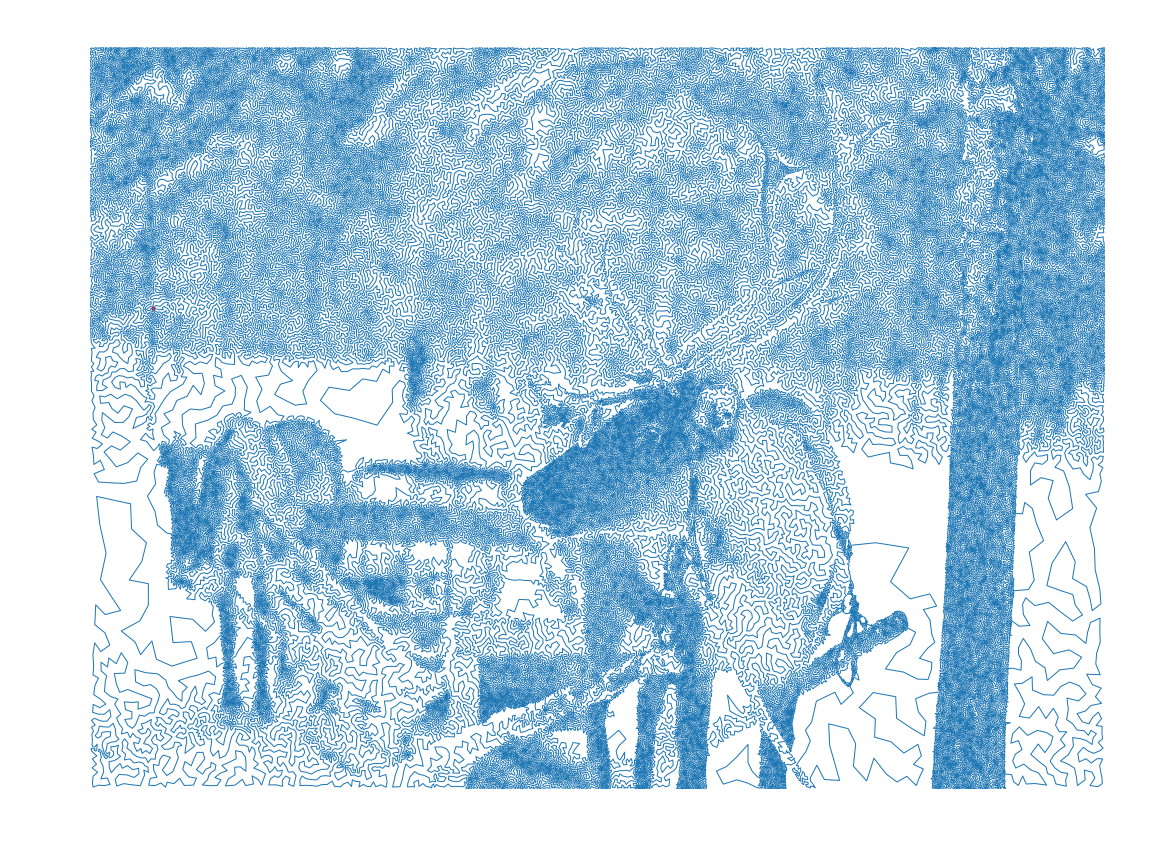

In [242]:
plot_path(path)

In [255]:
cnt = 0
for i in range(0, len(path), 10):
    if isprime(i-1):
        cnt += 1
cnt
# 4439

4439